In [2]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns
import tikzplotlib as tikz

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess as pre
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [12]:
path = '/home/leonriccius/Desktop/CurvedBackwardFacingStep/Re13700_kOmega_150_ml'
rans_time = max([int(entry) for entry in os.listdir(path) if entry.isnumeric()])
print(rans_time)

grid = pre.readCellCenters(rans_time, path)
u_rans = pre.readVectorData(rans_time, 'U', path)
u_levm = pre.readVectorData('3000', 'U', path)

path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata/CurvedBackwardFacingStep/13700'
u_dns = th.load(os.sep.join([path_dns, 'u_dns-torch.th']))

5000
Reading mesh cell centers /home/leonriccius/Desktop/CurvedBackwardFacingStep/Re13700_kOmega_150_ml/5000/cellCenters
Attempting to read file: /home/leonriccius/Desktop/CurvedBackwardFacingStep/Re13700_kOmega_150_ml/5000/U
Parsing file...
Data field file successfully read.
Attempting to read file: /home/leonriccius/Desktop/CurvedBackwardFacingStep/Re13700_kOmega_150_ml/3000/U
Parsing file...
Data field file successfully read.


In [11]:
grid_dns.shape

torch.Size([21000, 3])

In [19]:
th.max(u_dns)

tensor(nan, dtype=torch.float64)

In [7]:
# find an remove nan entries of dns data
index = u_dns[:,0] != u_dns[:,0]
# u_dns[index] = th.zeros(1,3, dtype=float)
# fig, ax = plt.subplots()
# ax.scatter(grid[:,0], grid[:,1], c=u_dns[:,0])

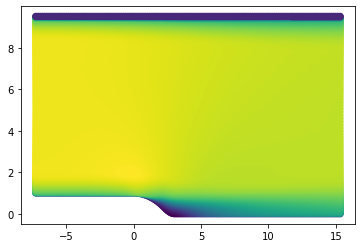

In [29]:
u_dns[th.isnan(u_dns[:,0])] = th.zeros(1,3, dtype=float)
fig, ax = plt.subplots()
ax.scatter(grid[:,0], grid[:,1], c=u_dns[:,0])

-7.2587857 15.318786
-7.258785724639893 15.318785667419434


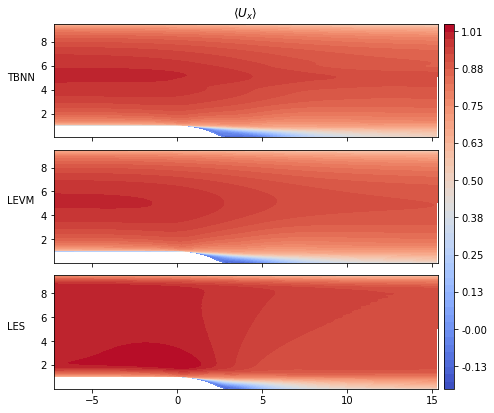

In [40]:
nrows = 3
ncols = 1
s = 1.5

idx = [0]

ref = 20
gamma = 1
x_min, x_max = np.min(grid_rans[:,0].numpy()), np.max(grid_rans[:,0].numpy())
x_mean = 0.5*(x_max - x_min)
x_min_neu = x_mean - gamma*(x_mean - x_min)
x_max_neu = x_mean - gamma*(x_mean - x_max)

y_min, y_max = np.min(grid_rans[:,1].numpy()), np.max(grid_rans[:,1].numpy())
y_mean = 0.5*(y_max - y_min)
y_min_neu = y_mean - gamma*(y_mean - y_min)
y_max_neu = y_mean - gamma*(y_mean - y_max)

print(x_min, x_max)
print(x_min_neu, x_max_neu)
x_min, x_max = x_min_neu, x_max_neu
y_min, y_max = y_min_neu, y_max_neu

nx = int(ref*(x_max - x_min))
ny = int(ref*(y_max - y_min))

grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
grid_y_shifted = cbfs_interp(grid_x)*(y_max - grid_y)/y_max + grid_y

grid_u_rans = griddata(grid_rans[:,0:2], u_rans.detach().numpy()[:,idx[0]], (grid_x, grid_y_shifted), method = 'linear')
grid_u_levm = griddata(grid_rans[:,0:2], u_levm.detach().numpy()[:,idx[0]], (grid_x, grid_y_shifted), method = 'linear')
grid_u_dns = griddata(grid_dns[:,0:2], u_dns.detach().numpy()[:,idx[0]], (grid_x, grid_y_shifted), method = 'linear') #, fill_value=0.)

# get min an max of (b_pred, b_test) for colormap
tmp = th.cat((u_rans[:,idx[0]], u_dns[:,idx[0]])).detach().numpy()
b_min = np.min(tmp)
b_max = np.max(tmp)
levels = np.linspace(b_min, b_max, 50)

# # create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.5*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)

cmap = matplotlib.cm.get_cmap("coolwarm")
# cmap.set_over([0.70567315799999997, 0.015556159999999999, 0.15023281199999999, 1.0])
# cmap.set_under([0.2298057, 0.298717966, 0.75368315299999999, 1.0])

rans_plot = ax[0].contourf(grid_x, grid_y_shifted, grid_u_rans, levels = levels, cmap=cmap)
levm_plot = ax[1].contourf(grid_x, grid_y_shifted, grid_u_levm, levels = levels, cmap=cmap)
dns_plot = ax[2].contourf(grid_x, grid_y_shifted, grid_u_dns, levels = levels, cmap=cmap)

# fig.colorbar(b_dd_plot, ax=ax.flat, aspect=15*ncols*nrows, format='%.2f', pad=0.0)
fig.colorbar(rans_plot, ax=ax.flat, aspect=15*ncols*nrows, format='%.2f', pad=0.0)
# fig.colorbar(b_dns_plot, ax=ax[1], aspect=15*ncols*nrows, format='%.2f', pad=0.0)

x_off = -10.
y_off = 5.

ax[0].set_title(r'$\langle U_x \rangle$')

ax[0].text(x_off,y_off, r'TBNN', fontsize='medium', ha='left', va='center')
ax[1].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left')
ax[2].text(x_off,y_off, r'LES', fontsize='medium', ha='left')


# save fig
fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN'
fig_name =  time() + '_cbfs_13700_forward_U_x.pdf'
plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')